
# Содержание

1. [Успешность прототипа](#Успешность-прототипа)
2. [Сравнение групп платящих игроков](#Сравнение-групп-платящих-игроков)
3. [Предсказание оттока](#Предсказание-оттока)
4. [Эффективность рекламных кампаний](#Эффективность-рекламных-кампаний)
5. [Связь рекламного трафика и органического](#Связь-рекламного-трафика-и-органического)


# Успешность прототипа
**Известно что компания конкурент выпустила 1000 прототипов игр, из которых было 5 успешных. Наша компания выпустила 200 прототипов из которых ни один не был успешен.
Какова вероятность что следующий (201й) наш прототип будет успешен? Решите задачу классическим и баесовским подходами.**


**Решение**

Пусть $k$ - число успешных прототипов, а $n$ - общее число прототипов

**Классический подход**

По классическому определению вероятности ($P = k / n$) вероятность успеха у компании-конкурента: $P = 5/1000 = 0.005$. Если предположить, что вероятность успеха для нашей компании такая же, как и для конкурента (0.005), то вероятность того, что 201-й прототип будет успешен будет равна 0.005

**Байесовский подход**

Будем использовать бета-распределение. Мы уже знаем, что у компании-конкурента 5 успешных игр из 1000. Используем эти параметры: Beta(5,995) распределение - априорное с параметрами $α_p = 5$ - число успехов и $β_p = 995$ - число провалов. Рассчитаем параметры для апостериорного распределения: 

$α = α_p + k = 5 + 0 = 5$, 

$β = β_p + n - k = 995 + 200 - 0 = 1195$

Найдем вероятность следующего успеха как $P = \frac{α}{(α + β)}$

$P = \frac{α}{(α + β)} = \frac{5} {(5 + 1195)} = 0.00417$


# Сравнение групп платящих игроков
В мобильной игре около 10% игроков совершает платежи в первый месяц с момента установки игры (база расчета - 500 игроков). 
Геймдизайнеры разработали обновление которое по их экспертной оценке должно увеличить процент плательщиков с 10% до 11%. Цель эксперимента - подтвердить или опровергнуть их гипотезу.
Геймдизайнеры разработали обновление которое по их экспертной оценке должно увеличить процент плательщиков с 10% до 11%. Цель эксперимента - подтвердить или опровергнуть их гипотезу.

    1.	Опишите оптимальный по вашему мнению дизайн эксперимента
    2.	Рассчитайте длительность эксперимента при условии что каждый день в игру приходит около 100 новых игроков.
    3.	Самостоятельно сгенерируйте датасет с около 10% плательщиков (контроль) и рассчитайте 95% HDI / CI.
    4.	Сгенерируйте несколько вариантов экспериментальной группы (хуже, лучше, без эффекта), рассчитайте силу эффекта, HDI / CI и ваши выводы для каждого варианта.
    5.	Решите задачу 2 разными подходами: frequentist / bayesian
Необходимо все ответы сопроводить комментариями почему вы выбрали ту или иную методику расчета, алгоритм и т.д.


**Решение**


**1. Дизайн эксперимента**

Сформулируем гипотезы: 

Нулевая гипотеза (H0): Процент плательщиков остается 10%.

Альтернативная гипотеза (H1): Процент плательщиков увеличивается до 11%.


Рандомизация: Новые игроки (по 100 новых игроков в день) будут случайным образом распределены на контрольную группу (без обновления) и экспериментальную группу (с обновлением). Можно придерживаться соотношения 1:1 (50% на 50%), если нет специальных ограничений, это обеспечит максимальную статистическую мощность. 

Нужно заранее определить продолжительность эксперимента (будет рассчитана далее).

Нужно определить целевую метрику, за которой будем следить: в нашей задаче это процент платящих игроков в течение первого месяца. Также можно отслеживать и дополнительные метрики: ARPU, удержание, среднее количество покупок на одного платящего. Можно также определить барьерную метрику, которая не должна упасть (маржа, например)

**2. Длительность эксперимента**

Определим мощность как 80% и уровень значимости как 5%. Рассчитаем размер каждой выборки

In [1]:
import warnings
warnings.filterwarnings('ignore')
import statsmodels.stats.api as sms
es = sms.proportion_effectsize(0.10, 0.11)
size = sms.NormalIndPower().solve_power(es, power=0.80, alpha=0.05, ratio=1)
print(f'В каждой выборке {size:.0f} человек, всего {size*2:.0f} человек')


В каждой выборке 14744 человек, всего 29488 человек


В игру ежедневно приходит около 100 новых игроков, значит потребуется 295 дней.

**3. Расчет 95% HDI/CI для контроля**


Сгенерируем данные

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm, beta
from statsmodels.stats.proportion import proportions_ztest

np.random.seed(0)

control_data = np.random.binomial(1, 0.10, 500)
control_df = pd.DataFrame({'group': 'control', 'payment': control_data})

In [3]:
def calculate_metrics(data, confidence=0.95):
    """
    Рассчитывает 95% HDI/CI для заданных данных.
    
    :param data: numpy array или pandas Series с данными (0 или 1, где 1 - успех)
    :param confidence: доверительный интервал, по умолчанию 0.95
    :return: словарь с рассчитанными метриками
    """
    # Пропорция
    successes = data.sum()
    total = len(data)
    proportion = successes / total
    
    # Частотный подход
    std_error = np.sqrt(proportion * (1 - proportion) / total)
    ci_lower, ci_upper = norm.interval(confidence, loc=proportion, scale=std_error)
    
    # Байесовский подход
    alpha_param = successes + 1
    beta_param = total - successes + 1
    posterior = beta(alpha_param, beta_param)
    hdi_lower, hdi_upper = posterior.interval(0.95)
        
    return {
        'proportion': proportion,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'hdi_lower': hdi_lower,
        'hdi_upper': hdi_upper,
        'successes': successes,
        'total': total
    }


In [4]:
control_metrics = calculate_metrics(control_df['payment'])
group = 'Контроль'
print(f"{group} - Пропорция: {control_metrics['proportion']:.4f}")
print(f"{group} - 95% CI: ({control_metrics['ci_lower']:.4f}, {control_metrics['ci_upper']:.4f})")
print(f"{group} - 95% HDI: ({control_metrics['hdi_lower']:.4f}, {control_metrics['hdi_upper']:.4f})")

Контроль - Пропорция: 0.1140
Контроль - 95% CI: (0.0861, 0.1419)
Контроль - 95% HDI: (0.0891, 0.1449)


**4. Расчет 95% HDI/CI для экспериментальных групп**

Сгенерируем данные

In [5]:
experiment_data_no_effect = np.random.binomial(1, 0.10, 500)
experiment_data_better = np.random.binomial(1, 0.11, 500)
experiment_data_worse = np.random.binomial(1, 0.09, 500)

experiment_df_no_effect = pd.DataFrame({'group': 'experiment_no_effect', 'payment': experiment_data_no_effect})
experiment_df_better = pd.DataFrame({'group': 'experiment_better', 'payment': experiment_data_better})
experiment_df_worse = pd.DataFrame({'group': 'experiment_worse', 'payment': experiment_data_worse})

experiment_df = pd.concat([experiment_df_no_effect, experiment_df_better, experiment_df_worse])

И выведем метрики

In [6]:
groups = experiment_df.groupby('group')['payment']
for group, data in groups:
    metrics = calculate_metrics(data)
    print(f"{group} - Пропорция: {metrics['proportion']:.4f}")
    print(f"{group} - 95% CI: ({metrics['ci_lower']:.4f}, {metrics['ci_upper']:.4f})")
    print(f"{group} - 95% HDI: ({metrics['hdi_lower']:.4f}, {metrics['hdi_upper']:.4f})")
    print()

experiment_better - Пропорция: 0.1400
experiment_better - 95% CI: (0.1096, 0.1704)
experiment_better - 95% HDI: (0.1124, 0.1732)

experiment_no_effect - Пропорция: 0.1020
experiment_no_effect - 95% CI: (0.0755, 0.1285)
experiment_no_effect - 95% HDI: (0.0785, 0.1317)

experiment_worse - Пропорция: 0.0940
experiment_worse - 95% CI: (0.0684, 0.1196)
experiment_worse - 95% HDI: (0.0715, 0.1228)



**Выводы**

- Контрольная группа и экспериментальная группа без эффекта: Как 95% CI, так и 95% HDI перекрываются

- Экспериментальная группа с улучшением: Как 95% CI, так и 95% HDI смещены вверх по сравнению с контрольной группой

- Экспериментальная группа с ухудшением: Как 95% CI, так и 95% HDI смещены вниз по сравнению с контрольной группой

**Сила эффекта**

Проведем z-тест. Z-тест является одним из наиболее распространенных методов для сравнения пропорций между двумя группами (контрольной и экспериментальной). Он чувствителен к размеру выборки, но во всех наших группах по 500 человек, поэтому пробуем.


- Нулевая гипотеза: Пропорции платящих игроков в контрольной и экспериментальной группе одинаковы.
- Альтернативная гипотеза: Пропорции платящих игроков в контрольной и экспериментальной группе различаются.

In [7]:
def z_test_proportions(control_metrics, exp_metrics):
    """
    Проводит Z-тест для пропорций между контрольной и экспериментальной группами.
    
    :param control_metrics: Словарь с метриками контрольной группы
    :param exp_metrics: Словарь с метриками экспериментальной группы
    :return: Словарь с результатами Z-теста
    """
    count = np.array([exp_metrics['successes'], control_metrics['successes']])
    nobs = np.array([exp_metrics['total'], control_metrics['total']])
    stat, p_value = proportions_ztest(count, nobs, alternative = 'larger')
    
    return {
        'z_stat': stat,
        'p_value': p_value
    }

In [8]:
groups = experiment_df.groupby('group')['payment']
for group, data in groups:
    metrics = calculate_metrics(data)
    test_results_no_effect = z_test_proportions(control_metrics, metrics)
    stat = test_results_no_effect['z_stat']
    p_value = test_results_no_effect['p_value']
    print(f"{group} - Z-тест: статистика = {stat:.4f}, p-значение = {p_value:.4f}")
    print()

experiment_better - Z-тест: статистика = 1.2346, p-значение = 0.1085

experiment_no_effect - Z-тест: статистика = -0.6113, p-значение = 0.7295

experiment_worse - Z-тест: статистика = -1.0359, p-значение = 0.8499



**Выводы**

Как и предполагалось, на 1000 игроках выявить такое различие трудно. Для всех экспериментальных групп p-значение больше уровня значимости 0.05, а значит, нет оснований утверждать, что пропорции платящих игроков в контрольной и экспериментальной группе различаются.

**Дополнительно**

Для мобильной игры 295 дней очень большой срок, некоторые игры вообще столько не живут. Кроме того, в формулировке вопроса написано 'около 10% игроков', то есть значение неточное. Возможно, эффект есть, но нам не хватает мощности его увидеть. Сравним worse-группу с better

In [9]:
exp_worse_metrics = calculate_metrics(experiment_df_worse['payment'])
exp_better_metrics = calculate_metrics(experiment_df_better['payment'])
test_results_better = z_test_proportions(exp_worse_metrics, exp_better_metrics)
print(f"Z-тест: статистика = {test_results_better['z_stat']:.4f}, p-значение = {test_results_better['p_value']:.4f}")

Z-тест: статистика = 2.2628, p-значение = 0.0118


Здесь уже p-значение ниже 0.05. Лучше перед проведением теста уточнить процент платящих пользователей (посчитать на большей базе, если есть возможность) и если оно будет ближе к 9%, то есть к worse-группе, то длительность эксперимента можно снизить. Важно сделать все расчеты до начала самого эксперимента

# Предсказание оттока
В мобильной игре, после установки и запуска игры начинается туториал - игрок проходит обучение игре, которое состоит из нескольких последовательных шагов. 
Данные представляют собой набор строк - уникальный id игрока, datetime и номер шага туториала который пройден игроком.
Геймдизайнеры выдвинули гипотезу - если мы с высокой вероятностью сможем предсказать шаг на котором игрок уйдет из игры заранее, то запустив альтернативное продолжение туториала с этого шага мы избежим оттока и увеличим прохождение туториала.
1.	Как бы вы решали задачу предсказания отвала игрока?
2.	Как оценить качество полученной модели? Опишите методы которые знаете и какой считаете оптимальным и почему.
3.	Предположим что вы разработали модель которая с достаточной вероятностью предсказывает отвал. Опишите дизайн эксперимента и методологию по проверке гипотезы геймдизайнеров


**Решение**


1. Считаем, что данные предобработаны. Шаги в туториале последовательные, значит, будем считать, что максимальный шаг туториала соответствует максимальному datetime. Предсказание отвала - задача классификации. Создадим таргетный столбец. Определим целевую переменную как бинарный столбец, где 0 обозначает, что игрок завершил шаг (шаг не максимальный для этого id), а 1 - что он отвалился (шаг максимальный для этого id). Нужно также знать общее количество шагов, поскольку если максимальный шаг - заключительный, то игрок не отвалился, а благополучно завершил туториал. Скорее всего, получим дисбаланс классов, это нужно будет учесть в параметрах модели. Также нужно создать новые признаки, например, продолжительность времени на каждом шаге. Поскольку признаков мало, то лучше использовать простые модели, например, логистическую регрессию, дерево решений, случайный лес. Можно попробовать подобрать гиперпараметры разных моделей и посмотреть на метрику на валидации. Затем проверить лучшую модель на тесте.

2. Можно выводить сразу несколько метрик, но особое внимание я бы обращала на F1. F1 объединяет точность и полноту, подходит для несбалансированных классов. Кроме того, можно использовать кросс-валидацию и определять среднюю метрику по группам

3. Цель: определить, увеличивает ли альтернативное продолжение процент прохождения туториала. Сформулируем гипотезы: 

    Нулевая гипотеза (H0): Процент прохождения туториала остается неизменным. 

    Альтернативная гипотеза (H1): Процент прохождения туториала увеличивается.

    Рандомизация: Игроки случайным образом будут распределены на контрольную группу (без обновления) и экспериментальную группу (с обновлением). Можно придерживаться соотношения 1:1 (50% на 50%), если нет специальных ограничений, это обеспечит максимальную статистическую мощность.

    Нужно заранее определить продолжительность эксперимента.

    Нужно определить целевую метрику, за которой будем следить: в нашей задаче это процент прохождения туториала. Также можно следить за временем прохождения туториала, средним временем на шаг. 
    
    Для оценки значимости различий между группами можно использовать Z-тест или Т-тест. 

# Эффективность рекламных кампаний
Отдел маркетинга оперирует некоторым множеством рекламных кампаний. Первая часть оперирования состоит из запуска тестовых рекламных кампаний, у которых есть требования по KPI при достижении которых тест считается успешным.
Успешные тесты переходят в разряд постоянных кампаний и вторая часть оперирования состоит из мониторинга постоянных кампаний - управление бюджетом кампании (COST) и мониторинг ее доходов (REVENUE), а так же соотношением доходов к расходам.
Главный KPI для постоянных рекламных кампаний - ROAS на 60й день, т.е. какой процент от расходов кампания возвращает на 60й день.
Для выполнения задачи необходимо использовать тестовый датасет (2 таблицы по расходам и доходам).
1.	Отдел маркетинга руководствуется гипотезой - чем больший COST расходуется на кампанию тем ниже ROAS 60го дня (рост CPI при увеличении объёма закупки при сохранении того же LTV 60го дня). На основании данных подтвердите или опровергните эту гипотезу. Исходите из того что мы точно знаем что CPI зависит от объема нелинейно, вопрос в том как эту зависимость описать и учесть во 2м вопросе.
2.	По каждой рекламной кампании рассчитайте суточный рекламный бюджет который максимизирует абсолютную маркетинговую прибыль рекламной кампании (REVENUE 60 дня минус COST).
3.	Исходя из пункта 2 по каждой рекламной кампании дайте ваше заключение о том насколько нужно увеличить / уменьшить ее суточный бюджет либо вообще остановить.
4.	Решите проблему рекламных кампаний по которым еще нет полных 60 дней. Объясните почему ваше решение оптимально


**Решение**


Загрузим таблицы и посмотрим на них

In [10]:
import zipfile
import sqlite3

# Пути
zip_path = 'testcase.db.zip'
extracted_path = 'testcase.db'

# Извлечение файла из ZIP-архива
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extract(extracted_path)

# Подключение к базе данных SQLite
conn = sqlite3.connect(extracted_path)
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

source_comparison = pd.read_sql_query('SELECT * FROM source_comparison', conn)
costs = pd.read_sql_query('SELECT * FROM costs', conn)
revenue = pd.read_sql_query('SELECT * FROM revenue', conn)

# Печать списка таблиц
print("Таблицы в базе данных:")
for table in tables:
    print(table[0])

# Печать первых 10 строк из каждой таблицы вместе с названиями колонок
for table in tables:
    table_name = table[0]
    print(f"\nСодержимое таблицы {table_name}:")

    cursor.execute(f"PRAGMA table_info({table_name});")
    columns_info = cursor.fetchall()
    column_names = [col[1] for col in columns_info]
    print(" | ".join(column_names))

    cursor.execute(f"SELECT * FROM {table_name} LIMIT 10;")
    rows = cursor.fetchall()
    for row in rows:
        print(" | ".join(str(cell) for cell in row))

conn.close()


Таблицы в базе данных:
source_comparison
costs
revenue

Содержимое таблицы source_comparison:
Install_Dates | source_type | Country | installs
2020-05-18 | Paid | PY | 4.0
2020-04-14 | Paid | FR | 35.0
2020-04-30 | Paid | JP | 25.0
2020-03-20 | Paid | DE | 11.0
2020-04-30 | Paid | IT | 8.0
2020-05-17 | Paid | KE | 2.0
2020-04-06 | Paid | NZ | 19.0
2020-03-21 | Organic | EG | 24.0
2020-04-28 | Paid | UA | 826.0
2020-04-24 | Paid | IR | 9.0

Содержимое таблицы costs:
Install_Dates | campaign_id | Country | installs | spends
2020-04-14 | 90570 | CZ | 35.0 | 19.79
2020-04-28 | 90619 | AT | 5.0 | 4.99
2020-05-10 | 794235 | PK | 79.0 | 0.4
2020-05-07 | 91872 | FR | 12.0 | 9.56
2020-04-03 | 19115 | JP | 6.0 | 3.39
2020-03-27 | 19115 | UA | 221.0 | 38.84
2020-05-14 | 19115 | HK | 1.0 | 0.11
2020-05-04 | 794235 | LA | 7.0 | 0.04
2020-05-05 | 794235 | BD | 41.0 | 0.2
2020-04-13 | 790424 | RU | 181.0 | 43.19

Содержимое таблицы revenue:
Install_Dates | campaign_id | Country | 1d_LTV | 3d_LTV | 7d

Агрегируем данные. Рассчитаем ROAS_60d и marketing_profit

In [11]:
df = costs.merge(revenue, on=['Install_Dates', 'campaign_id', 'Country'])
aggregated_data = df.groupby(['campaign_id']).agg(installs = ('installs', 'sum'), 
                                                  days = ('Install_Dates', 'count'), total_spends = ('spends','sum'), 
                                                  total_revenue_60d = ('60d_LTV','sum')).reset_index()
aggregated_data['ROAS_60d'] = aggregated_data['total_revenue_60d'] / aggregated_data['total_spends']
aggregated_data['marketing_profit'] = aggregated_data['total_revenue_60d'] - aggregated_data['total_spends']
aggregated_data

,campaign_id,installs,days,total_spends,total_revenue_60d,ROAS_60d,marketing_profit
0,19115,89015.0,1645,30161.4300,23726.583781,0.786653,-6434.846219
1,22083,9187.0,578,9479.7572,619.413547,0.065341,-8860.343653
2,89897,103.0,10,194.9200,103.672651,0.531873,-91.247349
3,89917,296.0,38,617.7400,39.448237,0.063859,-578.291763
4,89985,164.0,12,155.3500,163.865598,1.054816,8.515598
...,...,...,...,...,...,...,...
224,803287,363.0,49,215.6200,225.775717,1.047100,10.155717
225,803393,522.0,19,91.2200,11.276038,0.123614,-79.943962
226,803472,121.0,12,131.5000,13.738535,0.104476,-117.761465
227,803588,14052.0,27,1326.4800,1304.632815,0.983530,-21.847185


Построим график ROAS_60d от total_spends

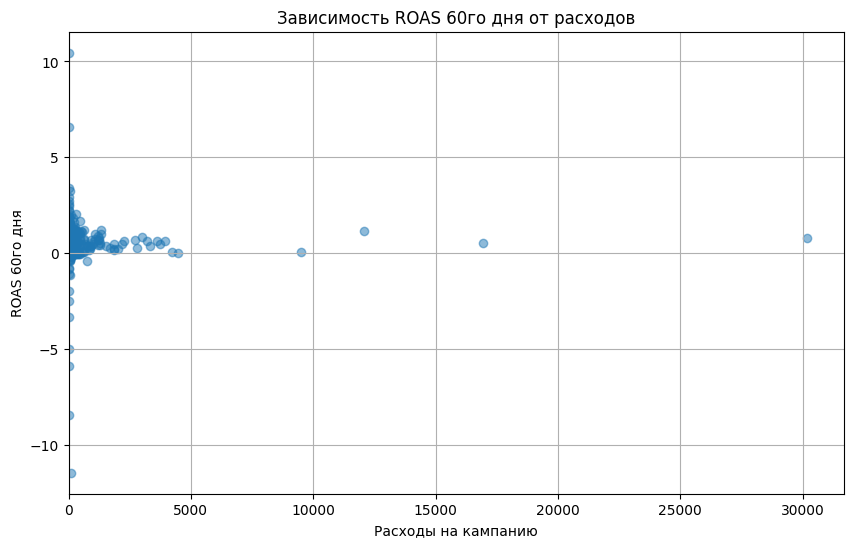

In [12]:
import matplotlib.pyplot as plt
def plot(x_max=None):
    plt.figure(figsize=(10, 6))
    plt.scatter(aggregated_data['total_spends'], aggregated_data['ROAS_60d'], alpha=0.5)
    plt.xlim([0,x_max])
    plt.title('Зависимость ROAS 60го дня от расходов')
    plt.xlabel('Расходы на кампанию')
    plt.ylabel('ROAS 60го дня')
    plt.grid(True)
    plt.show()
    
plot()

Посмотрим на начальный участок ближе

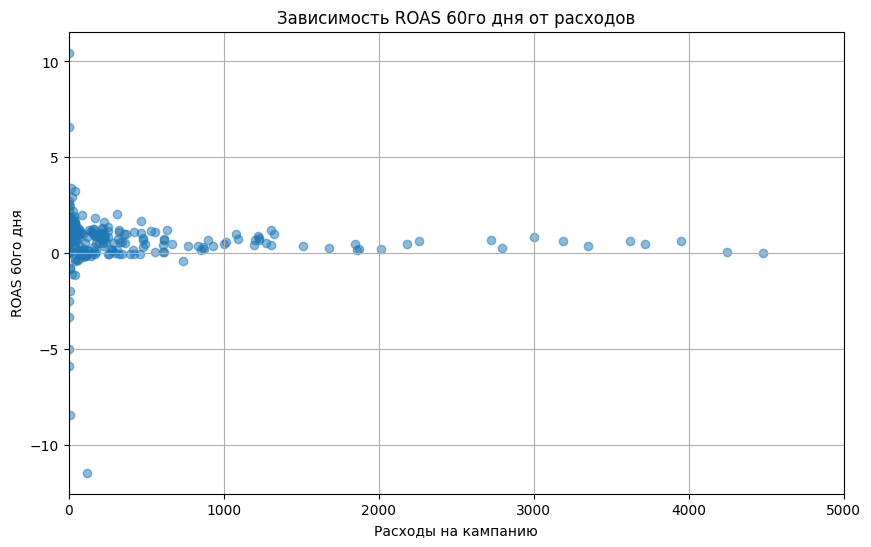

In [13]:
plot(5000)

При низких расходах (менее 1000) наблюдается большое разнообразие значений ROAS. С увеличением расходов на кампанию разброс снижается, ROAS концентрируется около нуля.

In [14]:
aggregated_data[['ROAS_60d', 'total_spends']].corr()

,ROAS_60d,total_spends
ROAS_60d,1.000000,0.001062
total_spends,0.001062,1.000000


Коэффициент корреляции Пирсона около нуля, линейной зависимости нет, гипотеза отдела маркетинга не подтверждается

Будем считать, что отрицательные значения в 60d_LTV означает, что нет полных 60 дней по этой кампании. Можно отфильтровать такие кампаний или же для них мы можем спрогнозировать значение для заполнения на основе существующих данных.
Попробуем сначала отфильтровать

In [15]:
aggregated_data_f = aggregated_data[aggregated_data['total_revenue_60d']>=0]
aggregated_data_f.sort_values('marketing_profit')

,campaign_id,installs,days,total_spends,total_revenue_60d,ROAS_60d,marketing_profit
1,22083,9187.0,578,9479.7572,619.413547,0.065341,-8860.343653
77,160845,92345.0,62,16937.7700,9063.716103,0.535119,-7874.053897
0,19115,89015.0,1645,30161.4300,23726.583781,0.786653,-6434.846219
172,789602,0.0,14,4477.8683,0.000000,0.000000,-4477.868300
174,789721,24493.0,40,4246.0300,266.947717,0.062870,-3979.082283
...,...,...,...,...,...,...,...
117,787847,1599.0,31,171.6600,311.664668,1.815593,140.004668
110,787481,3423.0,41,1308.1000,1599.475665,1.222747,291.375665
205,791872,317.0,26,468.6400,783.795258,1.672489,315.155258
95,786843,7859.0,37,313.2200,645.964254,2.062334,332.744254


Видим, что marketing_profit может быть как положительным, так и отрицательным. Сейчас траты по дням распределены неравномерно, а нам нужно установить равный по дням CPD. Рассчитаем средний CPD и CPI

In [16]:
aggregated_data_f['CPI'] = aggregated_data_f['total_spends']/aggregated_data_f['installs']
aggregated_data_f['CPD'] = aggregated_data_f['total_spends']/aggregated_data_f['days']
aggregated_data_f

,campaign_id,installs,days,total_spends,total_revenue_60d,ROAS_60d,marketing_profit,CPI,CPD
0,19115,89015.0,1645,30161.4300,23726.583781,0.786653,-6434.846219,0.338835,18.335216
1,22083,9187.0,578,9479.7572,619.413547,0.065341,-8860.343653,1.031866,16.400964
2,89897,103.0,10,194.9200,103.672651,0.531873,-91.247349,1.892427,19.492000
3,89917,296.0,38,617.7400,39.448237,0.063859,-578.291763,2.086959,16.256316
4,89985,164.0,12,155.3500,163.865598,1.054816,8.515598,0.947256,12.945833
...,...,...,...,...,...,...,...,...,...
221,803170,3232.0,43,1872.2900,426.079143,0.227571,-1446.210857,0.579298,43.541628
224,803287,363.0,49,215.6200,225.775717,1.047100,10.155717,0.593994,4.400408
225,803393,522.0,19,91.2200,11.276038,0.123614,-79.943962,0.174751,4.801053
226,803472,121.0,12,131.5000,13.738535,0.104476,-117.761465,1.086777,10.958333


In [17]:
(aggregated_data_f['marketing_profit']<0).value_counts(normalize=True)*100

marketing_profit
True     64.705882
False    35.294118
Name: proportion, dtype: float64

Больше половины (64.7%) убыточных на 60 день кампаний, 35.3% с положительным профитом на 60 день. Добавим столбец со средним профитом в день

In [18]:
aggregated_data_f['profit_per_day'] = aggregated_data_f['marketing_profit']/aggregated_data_f['days']

Можно предложить минимизировать затраты на кампании с отрицательным marketing_profit, взяв определенный процент от CPD, например, 80%.

In [19]:
aggregated_data_f['adjusted_CPD'] = aggregated_data_f.apply(lambda row: row['CPD'] * 0.8 
                                                            if row['marketing_profit'] < 0 else row['CPD'], axis=1)
aggregated_data_f

,campaign_id,installs,days,total_spends,total_revenue_60d,ROAS_60d,marketing_profit,CPI,CPD,profit_per_day,adjusted_CPD
0,19115,89015.0,1645,30161.4300,23726.583781,0.786653,-6434.846219,0.338835,18.335216,-3.911761,14.668173
1,22083,9187.0,578,9479.7572,619.413547,0.065341,-8860.343653,1.031866,16.400964,-15.329314,13.120771
2,89897,103.0,10,194.9200,103.672651,0.531873,-91.247349,1.892427,19.492000,-9.124735,15.593600
3,89917,296.0,38,617.7400,39.448237,0.063859,-578.291763,2.086959,16.256316,-15.218204,13.005053
4,89985,164.0,12,155.3500,163.865598,1.054816,8.515598,0.947256,12.945833,0.709633,12.945833
...,...,...,...,...,...,...,...,...,...,...,...
221,803170,3232.0,43,1872.2900,426.079143,0.227571,-1446.210857,0.579298,43.541628,-33.632811,34.833302
224,803287,363.0,49,215.6200,225.775717,1.047100,10.155717,0.593994,4.400408,0.207260,4.400408
225,803393,522.0,19,91.2200,11.276038,0.123614,-79.943962,0.174751,4.801053,-4.207577,3.840842
226,803472,121.0,12,131.5000,13.738535,0.104476,-117.761465,1.086777,10.958333,-9.813455,8.766667


Посмотирм на кампании с положительным marketing_profit.

In [20]:
aggregated_data_f[aggregated_data_f['marketing_profit']>=0].sort_values('profit_per_day', ascending=False).head()

,campaign_id,installs,days,total_spends,total_revenue_60d,ROAS_60d,marketing_profit,CPI,CPD,profit_per_day,adjusted_CPD
177,790034,87544.0,54,12076.27,13870.735633,1.148594,1794.465633,0.137945,223.634630,33.230845,223.634630
205,791872,317.0,26,468.64,783.795258,1.672489,315.155258,1.478360,18.024615,12.121356,18.024615
95,786843,7859.0,37,313.22,645.964254,2.062334,332.744254,0.039855,8.465405,8.993088,8.465405
110,787481,3423.0,41,1308.10,1599.475665,1.222747,291.375665,0.382150,31.904878,7.106724,31.904878
153,789050,230.0,18,39.78,129.333544,3.251220,89.553544,0.172957,2.210000,4.975197,2.210000


Для кампаний с максимальным профитом в день (profit_per_day) можно попробовать увеличить CPD. Если CPI низкий, значит мы привлекаем много дешевых клиентов. Если CPI высокий, значит мы привлекаем небольшое количество дорогих клиентов. Можно выбрать из них, на каких делать ставку.

# Связь рекламного трафика и органического
Приток новых игроков делится на 2 основных источника - рекламный и органический. Отдел маркетинг выдвигает гипотезу о связи рекламного и органического траффика: когда маркетологи привлекают больше рекламного траффика, растет и органический.
Для выполнения задачи необходимо использовать тестовый датасет (таблица source_comparison).
1.	Используя Causal Impact Analysis подтвердите или опровергните гипотезу маркетологов. Если вы ее опровергаете, то сформулируйте гипотезу которая кажется вам наиболее вероятной и проверьте ее
2.	Количественно рассчитайте вероятность что гипотеза маркетологов (или ваша) верна


**Решение**


Для начала нужно построить сводную по датам и разделением платного и органического источников

In [21]:
daily_data = source_comparison.groupby(['Install_Dates', 'source_type'])['installs'].sum().reset_index()
traffic_data = daily_data.pivot_table(index='Install_Dates', columns='source_type', values='installs', aggfunc='sum')
traffic_data.columns = ['Organic','Paid']
traffic_data

,Organic,Paid
Install_Dates,,
2020-03-18,8961.0,7359.0
2020-03-19,8457.0,6739.0
2020-03-20,8819.0,7254.0
2020-03-21,4485.0,9552.0
2020-03-22,5105.0,14804.0
...,...,...
2020-05-14,3324.0,8761.0
2020-05-15,3207.0,7031.0
2020-05-16,3732.0,7579.0


Далее нужно выбрать дату для Causal Impact Analysis, начиная с которой резко растет рекламный траффик. Можно оценить визуально или аналитически.

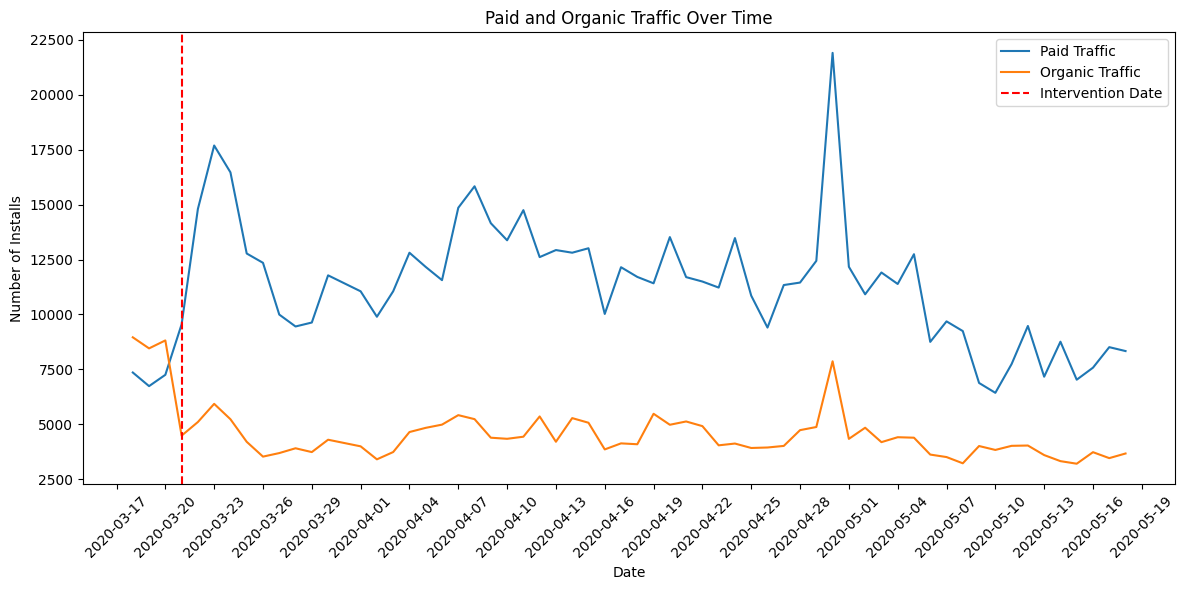

In [22]:
import matplotlib.dates as mdates
traffic_data.index = pd.to_datetime(traffic_data.index)

plt.figure(figsize=(12, 6))
plt.plot(traffic_data.index.values, traffic_data['Paid'].values, label='Paid Traffic')
plt.plot(traffic_data.index.values, traffic_data['Organic'].values, label='Organic Traffic')
plt.axvline(x=pd.to_datetime('2020-03-21'), color='r', linestyle='--', label='Intervention Date')
plt.xlabel('Date')
plt.ylabel('Number of Installs')
plt.legend()
plt.title('Paid and Organic Traffic Over Time')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()
